# Two layer fully connected Neural Network for CIFAR 10

### Class used for Neural Network is as below

In [24]:
# Class definition for two layer fully connected neural network
import numpy as np
import matplotlib.pyplot as plt
import math, time

class TwoLayerNet(object):
  """
  A two-layer fully-connected neural network. The net has an input dimension of
  N, a hidden layer dimension of H, and performs classification over C classes.
  We train the network with a softmax loss function and L2 regularization on the
  weight matrices. The network uses a ReLU nonlinearity after the first fully
  connected layer.
  In other words, the network has the following architecture:
  input - fully connected layer - ReLU - fully connected layer - softmax
  The outputs of the second fully-connected layer are the scores for each class.
  """

  def __init__(self, input_size, hidden_size, output_size, std=1e-4):
    """
    Initialize the model. Weights are initialized to small random values and
    biases are initialized to zero. Weights and biases are stored in the
    variable self.params, which is a dictionary with the following keys:
    W1: First layer weights; has shape (D, H)
    b1: First layer biases; has shape (H,)
    W2: Second layer weights; has shape (H, C)
    b2: Second layer biases; has shape (C,)
    Inputs:
    - input_size: The dimension D of the input data.
    - hidden_size: The number of neurons H in the hidden layer.
    - output_size: The number of classes C.
    """
    self.params = {}
    self.params['W1'] = std * np.random.randn(input_size, hidden_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['W2'] = std * np.random.randn(hidden_size, output_size)
    self.params['b2'] = np.zeros(output_size)

  def loss(self, X, y=None, reg=0.0):
    """
    Compute the loss and gradients for a two layer fully connected neural
    network.
    Inputs:
    - X: Input data of shape (N, D). Each X[i] is a training sample.
    - y: Vector of training labels. y[i] is the label for X[i], and each y[i] is
      an integer in the range 0 <= y[i] < C. This parameter is optional; if it
      is not passed then we only return scores, and if it is passed then we
      instead return the loss and gradients.
    - reg: Regularization strength.
    Returns:
    If y is None, return a matrix scores of shape (N, C) where scores[i, c] is
    the score for class c on input X[i].
    If y is not None, instead return a tuple of:
    - loss: Loss (data loss and regularization loss) for this batch of training
      samples.
    - grads: Dictionary mapping parameter names to gradients of those parameters
      with respect to the loss function; has the same keys as self.params.
    """
    # Unpack variables from the params dictionary
    W1, b1 = self.params['W1'], self.params['b1']
    W2, b2 = self.params['W2'], self.params['b2']
    N, D = X.shape

    # Compute the forward pass
    scores = None
    #############################################################################
    # TODO: Perform the forward pass, computing the class scores for the input. #
    # Store the result in the scores variable, which should be an array of      #
    # shape (N, C).                                                             #
    #############################################################################
    # Values of the hidden layer

    X1 = np.maximum( X.dot(W1) + b1, 0 )
    X2 = X1.dot(W2) + b2

    scores = X2
    #scores =  exp_X2
    
    #############################################################################
    #                              END OF YOUR CODE                             #
    #############################################################################
    
    # If the targets are not given then jump out, we're done
    if y is None:
      return scores
   
    # Creating a output matrix from output vector
    # X2 is the output
    Y = np.zeros(X2.shape)
    for i,row in enumerate(Y):
        row[y[i]] = 1
    
    # Compute the loss
    loss = 0.0
    #############################################################################
    # TODO: Finish the forward pass, and compute the loss. This should include  #
    # both the data loss and L2 regularization for W1 and W2. Store the result  #
    # in the variable loss, which should be a scalar. Use the Softmax           #
    # classifier loss. So that your results match ours, multiply the            #
    # regularization loss by 0.5                                                #
    #############################################################################
    
    #Exponentiating the X2 , then normalizing the exponentiated value
    exp_X2 = pow(math.e, X2)
    scores   = (exp_X2.T/np.sum(exp_X2, axis = 1)).T
    
    for i in range(N):
      loss -= np.log( scores[i][y[i]] )
    loss /= N
    loss += 0.5*reg*np.sum(W1 * W1)  
    loss += 0.5*reg*np.sum(W2 * W2)  
    #############################################################################
    #                              END OF YOUR CODE                             #
    #############################################################################

    # Backward pass: compute gradients
    grads = {}
    #############################################################################
    # TODO: Compute the backward pass, computing the derivatives of the weights #
    # and biases. Store the results in the grads dictionary. For example,       #
    # grads['W1'] should store the gradient on W1, and be a matrix of same size #
    #############################################################################

    #Back propagation
    dX2 = scores - Y
    dW2 = ((dX2.T).dot(X1)).T/N + reg*W2
    db2 = (dX2.T).dot(np.ones(X1.shape[0]))/N
    dX1 = dX2.dot(W2.T)
    dW1 = (((dX1*(X1>0)).T).dot(X)).T/N + reg*W1
    db1 = (((dX1*(X1>0)).T).dot(np.ones(X.shape[0]))).T/N
      
    grads['W2'] = dW2
    grads['b2'] = db2
    grads['W1'] = dW1
    grads['b1'] = db1
    
    #############################################################################
    #                              END OF YOUR CODE                             #
    #############################################################################

    return loss, grads

  def train(self, X, y, X_val, y_val,
            learning_rate=1e-3, learning_rate_decay=0.95,
            reg=1e-5, num_iters=100,
            batch_size=200, verbose=False ,dropout_fraction = 0):
    """
    Train this neural network using stochastic gradient descent.
    Inputs:
    - X: A numpy array of shape (N, D) giving training data.
    - y: A numpy array f shape (N,) giving training labels; y[i] = c means that
      X[i] has label c, where 0 <= c < C.
    - X_val: A numpy array of shape (N_val, D) giving validation data.
    - y_val: A numpy array of shape (N_val,) giving validation labels.
    - learning_rate: Scalar giving learning rate for optimization.
    - learning_rate_decay: Scalar giving factor used to decay the learning rate
      after each epoch.
    - reg: Scalar giving regularization strength.
    - num_iters: Number of steps to take when optimizing.
    - batch_size: Number of training examples to use per step.
    - verbose: boolean; if true print progress during optimization.
    """
    
    #Dropout
    Binom_variables = np.random.choice([0, 1], size=X.shape, p=[dropout_fraction,1-dropout_fraction])
    X = (X*Binom_variables)/(1-dropout_fraction)
    
    
    num_train = X.shape[0]
    iterations_per_epoch = max(num_train / batch_size, 1)
    val_acc = 0

    # Use SGD to optimize the parameters in self.model
    loss_history = []
    train_acc_history = []
    val_acc_history = []

    for it in xrange(num_iters):


      #########################################################################
      # TODO: Create a random minibatch of training data and labels, storing  #
      # them in X_batch and y_batch respectively.                             #
      #########################################################################
      batch_indicies = np.random.choice(num_train, batch_size, replace = False)
      X_batch = X[batch_indicies]
      y_batch = y[batch_indicies]
      #########################################################################
      #                             END OF YOUR CODE                          #
      #########################################################################

      # Compute loss and gradients using the current minibatch
      loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
      loss_history.append(loss)

      #########################################################################
      # TODO: Use the gradients in the grads dictionary to update the         #
      # parameters of the network (stored in the dictionary self.params)      #
      # using stochastic gradient descent. You'll need to use the gradients   #
      # stored in the grads dictionary defined above.                         #
      #########################################################################
      for variable in self.params:
          self.params[variable] -= learning_rate*grads[variable]
      #########################################################################
      #                             END OF YOUR CODE                          #
      #########################################################################

      if verbose and it % 100 == 0:
        val_acc = (self.predict(X_val) == y_val).mean()
        print 'iteration %d / %d: loss %f, val_acc %f' % (it, num_iters, loss, val_acc)

      # Every epoch, check train and val accuracy and decay learning rate.
      if it % iterations_per_epoch == 0:
        # Check accuracy
        train_acc = (self.predict(X_batch) == y_batch).mean()
        val_acc = (self.predict(X_val) == y_val).mean()
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)
        # Decay learning rate
        learning_rate *= learning_rate_decay

    return {
      'loss_history': loss_history,
      'train_acc_history': train_acc_history,
      'val_acc_history': val_acc_history,
    }

  def predict(self, X):
    """
    Use the trained weights of this two-layer network to predict labels for
    data points. For each data point we predict scores for each of the C
    classes, and assign each data point to the class with the highest score.
    Inputs:
    - X: A numpy array of shape (N, D) giving N D-dimensional data points to
      classify.
    Returns:
    - y_pred: A numpy array of shape (N,) giving predicted labels for each of
      the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
      to have class c, where 0 <= c < C.
    """
    y_pred = None

    ###########################################################################
    # TODO: Implement this function; it should be VERY simple!                #
    ###########################################################################
    X1 = np.maximum( X.dot(self.params['W1']) + self.params['b1'], 0 )
    X2 = X1.dot(self.params['W2']) + self.params['b2']
    exp_X2 = pow(math.e, X2)
    scores   = (exp_X2.T/np.sum(exp_X2, axis = 1)).T
    
    y_pred = np.argmax(scores, axis = 1)
    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################
    return y_pred

In [25]:
# Initial Setup for the python

get_ipython().magic(u'matplotlib inline')
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
get_ipython().magic(u'load_ext autoreload')
get_ipython().magic(u'autoreload 2')

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
  np.random.seed(0)
  return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
  np.random.seed(1)
  X = 10 * np.random.randn(num_inputs, input_size)
  y = np.array([0, 1, 2, 2, 1])
  return X, y

net = init_toy_model()
X, y = init_toy_data()



In [27]:
scores = net.loss(X)
print 'Your scores:'
print scores
print
print 'correct scores:'
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print correct_scores
print

# The difference should be very small. We get < 1e-7
print 'Difference between your scores and correct scores:'
print np.sum(np.abs(scores - correct_scores))

Your scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Difference between your scores and correct scores:
3.68027207459e-08


In [28]:
# # Forward pass: compute loss
# In the same function, implement the second part that computes the data and regularizaion loss.

# In[ ]:

loss, _ = net.loss(X, y, reg=0.1)
correct_loss = 1.30378789133

# should be very small, we get < 1e-12
print 'Difference between your loss and correct loss:'
print np.sum(np.abs(loss - correct_loss))



Difference between your loss and correct loss:
1.79856129989e-13


In [7]:
import numpy as np
from random import randrange

def eval_numerical_gradient(f, x, verbose=True, h=0.00001):
  """ 
  a naive implementation of numerical gradient of f at x 
  - f should be a function that takes a single argument
  - x is the point (numpy array) to evaluate the gradient at
  """ 

  fx = f(x) # evaluate function value at original point
  grad = np.zeros_like(x)
  # iterate over all indexes in x
  it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
  while not it.finished:

    # evaluate function at x+h
    ix = it.multi_index
    oldval = x[ix]
    x[ix] = oldval + h # increment by h
    fxph = f(x) # evalute f(x + h)
    x[ix] = oldval - h
    fxmh = f(x) # evaluate f(x - h)
    x[ix] = oldval # restore

    # compute the partial derivative with centered formula
    grad[ix] = (fxph - fxmh) / (2 * h) # the slope
    if verbose:
      print ix, grad[ix]
    it.iternext() # step to next dimension

  return grad

In [8]:
# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

loss, grads = net.loss(X, y, reg=0.1)

# these should all be less than 1e-8 or so
for param_name in grads:
  f = lambda W: net.loss(X, y, reg=0.1)[0]
  param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
  print '%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name]))


W1 max relative error: 3.561318e-09
W2 max relative error: 3.440708e-09
b2 max relative error: 4.447646e-11
b1 max relative error: 2.738420e-09


### Load the CIFAR10 Dataset

In [29]:
# Functions to load the CIFAR 10 dataset

import cPickle as pickle
import numpy as np
import os
from scipy.misc import imread

def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'rb') as f:
    datadict = pickle.load(f)
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(ROOT):
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1,6):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)    
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
  return Xtr, Ytr, Xte, Yte


In [30]:
# # Load the data
# Now that you have implemented a two-layer network that passes gradient checks and works on toy data, it's time to load up our favorite CIFAR-10 data so we can use it to train a classifier on a real dataset.


def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'datasets/CIFAR10'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape


Train data shape:  (49000L, 3072L)
Train labels shape:  (49000L,)
Validation data shape:  (1000L, 3072L)
Validation labels shape:  (1000L,)
Test data shape:  (1000L, 3072L)
Test labels shape:  (1000L,)


### Train the newtork and check the results

In [31]:
# # Train a network
# To train our network we will use SGD with momentum. In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a decay rate.


input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.5, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print 'Validation accuracy: ', val_acc

iteration 0 / 1000: loss 2.302977, val_acc 0.086000
iteration 100 / 1000: loss 2.302445, val_acc 0.163000
iteration 200 / 1000: loss 2.299590, val_acc 0.161000
iteration 300 / 1000: loss 2.255467, val_acc 0.160000
iteration 400 / 1000: loss 2.185498, val_acc 0.201000
iteration 500 / 1000: loss 2.123868, val_acc 0.202000
iteration 600 / 1000: loss 2.072979, val_acc 0.238000
iteration 700 / 1000: loss 1.985366, val_acc 0.258000
iteration 800 / 1000: loss 1.995427, val_acc 0.269000
iteration 900 / 1000: loss 2.019790, val_acc 0.281000
Validation accuracy:  0.282


### Visualize loss and Classification accuracy

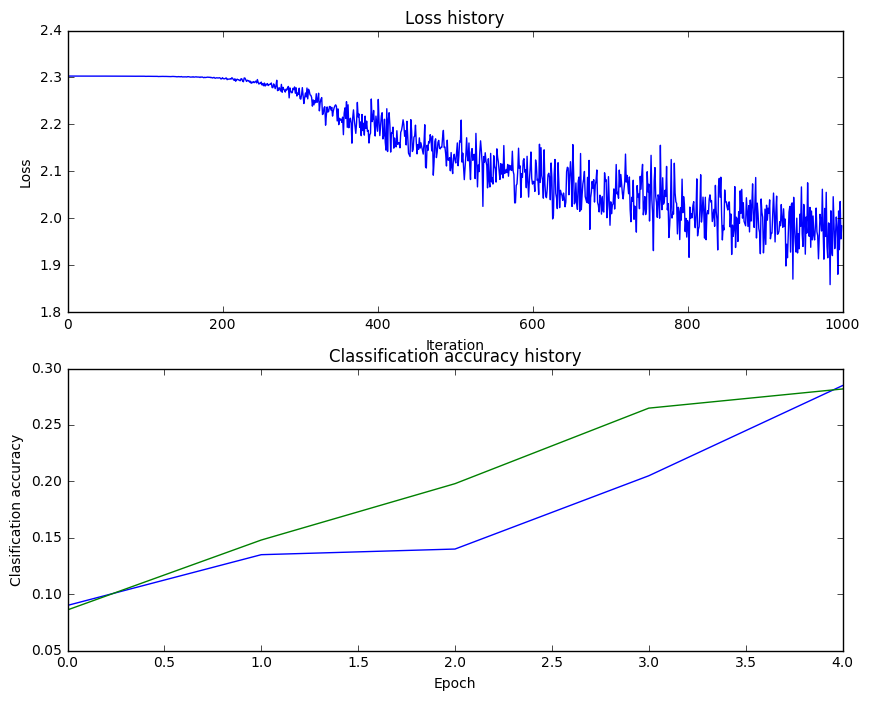

In [32]:
# # Debug the training
# With the default parameters we provided above, you should get a validation accuracy of about 0.29 on the validation set. This isn't very good.
# 
# One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.
# 
# Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()


### Visualize the weights that were learned in the first layer of the network

In [17]:
from math import sqrt, ceil
import numpy as np

def visualize_grid(Xs, ubound=255.0, padding=1):
  """
  Reshape a 4D tensor of image data to a grid for easy visualization.
  Inputs:
  - Xs: Data of shape (N, H, W, C)
  - ubound: Output grid will have values scaled to the range [0, ubound]
  - padding: The number of blank pixels between elements of the grid
  """
  (N, H, W, C) = Xs.shape
  grid_size = int(ceil(sqrt(N)))
  grid_height = H * grid_size + padding * (grid_size - 1)
  grid_width = W * grid_size + padding * (grid_size - 1)
  grid = np.zeros((grid_height, grid_width, C))
  next_idx = 0
  y0, y1 = 0, H
  for y in xrange(grid_size):
    x0, x1 = 0, W
    for x in xrange(grid_size):
      if next_idx < N:
        img = Xs[next_idx]
        low, high = np.min(img), np.max(img)
        grid[y0:y1, x0:x1] = ubound * (img - low) / (high - low)
        # grid[y0:y1, x0:x1] = Xs[next_idx]
        next_idx += 1
      x0 += W + padding
      x1 += W + padding
    y0 += H + padding
    y1 += H + padding
  # grid_max = np.max(grid)
  # grid_min = np.min(grid)
  # grid = ubound * (grid - grid_min) / (grid_max - grid_min)
  return grid

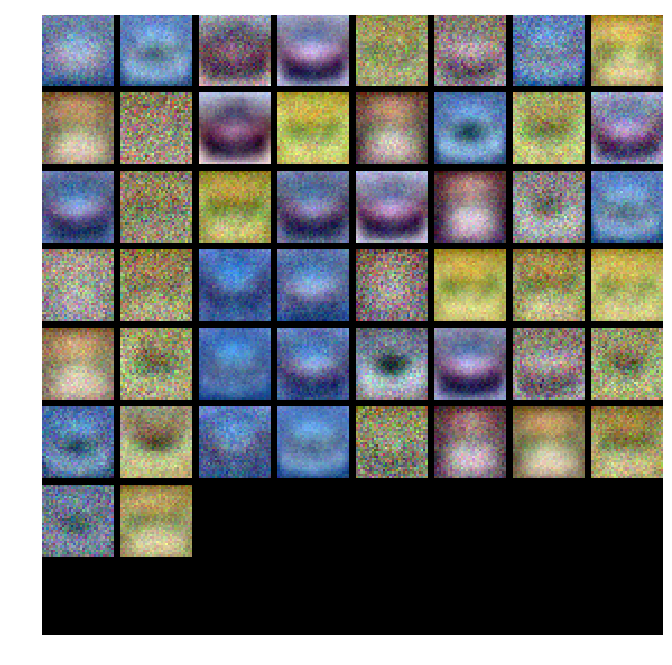

In [19]:
# Visualize the weights of the network

def show_net_weights(net):
  W1 = net.params['W1']
  W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
  plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
  plt.gca().axis('off')
  plt.show()

show_net_weights(net)


### Imp points to note  and Accuracy of Model :

In [33]:
 
# **What's wrong?**. Looking at the visualizations above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.
# 
# **Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including hidden layer size, learning rate, numer of training epochs, and regularization strength. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.
# 
# **Approximate results**. You should be aim to achieve a classification accuracy of greater than 48% on the validation set. Our best network gets over 52% on the validation set.
# 

# # Run on the test set
# When you are done experimenting, you should evaluate your final trained network on the test set; you should get above 48%.
# 
# **We will give you extra bonus point for every 1% of accuracy above 52%.**

# In[ ]:

test_acc = (net.predict(X_test) == y_test).mean()
print 'Final Test Accuracy: ', test_acc


Final Test Accuracy:  0.282


### Lets try to get better Accuracy by training network for more number of iterations

In [50]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=4000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.5, verbose=True)


iteration 0 / 4000: loss 2.302988, val_acc 0.094000
iteration 100 / 4000: loss 2.302517, val_acc 0.197000
iteration 200 / 4000: loss 2.297437, val_acc 0.178000
iteration 300 / 4000: loss 2.269782, val_acc 0.164000
iteration 400 / 4000: loss 2.217737, val_acc 0.200000
iteration 500 / 4000: loss 2.161237, val_acc 0.225000
iteration 600 / 4000: loss 2.103089, val_acc 0.244000
iteration 700 / 4000: loss 2.048040, val_acc 0.254000
iteration 800 / 4000: loss 1.905777, val_acc 0.264000
iteration 900 / 4000: loss 2.011713, val_acc 0.278000
iteration 1000 / 4000: loss 1.949247, val_acc 0.284000
iteration 1100 / 4000: loss 1.989590, val_acc 0.289000
iteration 1200 / 4000: loss 1.958343, val_acc 0.300000
iteration 1300 / 4000: loss 1.860057, val_acc 0.312000
iteration 1400 / 4000: loss 1.820303, val_acc 0.322000
iteration 1500 / 4000: loss 1.839268, val_acc 0.327000
iteration 1600 / 4000: loss 1.764119, val_acc 0.334000
iteration 1700 / 4000: loss 1.771647, val_acc 0.341000
iteration 1800 / 4000:

In [51]:
test_acc = (net.predict(X_test) == y_test).mean()
print 'Final Test Accuracy: ', test_acc


Final Test Accuracy:  0.394


## Test Results 

#### Iterations = 1000 , accuracy = 29%
#### Iterations = 2000 , accuracy = 36%
#### Iterations = 4000 , accuracy = 39%
#### Iterations = 10000 , accuracy = 43%